# Module 3 Final Project

- **Name**: Serena Quiroga
- **Date Submitted**: November 8, 2019
- **Course**: Flatiron Online Data Science Self-Paced
- **Instructor**: Eli Thomas
- **Blog Post**: http://squiroga8.github.io/an_intro_to_hypothesis_testing

# Overview of Requirements & Approach

For this project, I am working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company.

## DB Schema

<img src='https://raw.githubusercontent.com/learn-co-curriculum/dsc-mod-3-project/master/Northwind_ERD_updated.png'>

## Project Goal:
*The goal of this project is to query the database to get the data needed to perform a statistical analysis, including hypothesis testing, to answer the following questions:*
- Q1: **Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**
- Q2: **Is there a difference in performance between US and UK employees?** (Using number of orders)
- Q3: **Is there a difference in order processing time (from OrderDate to ShipDate) across the 3 different Shipping companies?**
- Q4: **Is there any interaction between Category and Customer Region in terms of total revenue per category?**

## Project Requirements:

Within this notebook, I will provide the following analyses:
- [x] Answer original hypothesis test (see above)
- [x] Test 3 additional Hypotheses
    - [x] For each hypothesis, specify both the null hypothesis and the alternative hypothesis for each question. 
    - [x] Also specify if this is one-tail or a two-tail test.
- [x] This notebook shows how I arrived at my results for each hypothesis test, including how I calculated my p-values.
- [x] This notebook also includes any other statistics that I find relevant to my analysis, such as effect size.
    
In addition to this notebook, this final project also includes the following:
- a Blog Post
- an Executive Summary/Non-Technical Presentation that explains the hypothesis tests I ran, my findings, and their relevance to company stakeholders (saved as a pdf in this repository).

# Data Retrieval

## Importing the libraries needed

In [272]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import scipy.stats as stats
import welchs_ttest_ddof_pvalue as welch
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Connecting to the Sqlite Database

In [273]:
conn = sqlite3.Connection('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()

In [78]:
# high-level overview of what tables are provided in this database
c.execute("""SELECT *FROM sqlite_master WHERE type = 'table';""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df

,type,name,tbl_name,rootpage,sql
0,table,Employee,Employee,2,"CREATE TABLE ""Employee"" \n(\n ""Id"" INTEGER PR..."
1,table,Category,Category,3,"CREATE TABLE ""Category"" \n(\n ""Id"" INTEGER PR..."
2,table,Customer,Customer,4,"CREATE TABLE ""Customer"" \n(\n ""Id"" VARCHAR(80..."
3,table,Shipper,Shipper,8,"CREATE TABLE ""Shipper"" \n(\n ""Id"" INTEGER PRI..."
4,table,Supplier,Supplier,9,"CREATE TABLE ""Supplier"" \n(\n ""Id"" INTEGER PR..."
5,table,Order,Order,11,"CREATE TABLE ""Order"" \n(\n ""Id"" INTEGER PRIMA..."
6,table,Product,Product,12,"CREATE TABLE ""Product"" \n(\n ""Id"" INTEGER PRI..."
7,table,OrderDetail,OrderDetail,14,"CREATE TABLE ""OrderDetail"" \n(\n ""Id"" VARCHAR..."
8,table,CustomerCustomerDemo,CustomerCustomerDemo,16,"CREATE TABLE ""CustomerCustomerDemo"" \n(\n ""Id..."
9,table,CustomerDemographic,CustomerDemographic,18,"CREATE TABLE ""CustomerDemographic"" \n(\n ""Id""..."


# EDA

## Overview of all tables:

While we currently have one hypothesis provided for testing, in order to generate 3 additional hypotheses to test we should begin by getting to know the other tables/data provided. I'll record my first impressions and initial curiosities, as I tend to find these original questions to be the least over-complicated. We will end this section with some formulated questions, so that in the next sections we can proceed to running the appropriate hypothesis tests.

In [79]:
# creating a list of tables in our database
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]

In [81]:
# Loop to put all tables into pandas dataframes, 
# credit: [https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb]
dfs = []
for i in tables:
    table = c.execute('SELECT * FROM "'+i+'" ' ).fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    foo = i+"_df" # to make a string into a variable name
    exec(foo + " = df") # to make TableName_df
    dfs.append(foo)

In [83]:
dfs

['Employee_df',
 'Category_df',
 'Customer_df',
 'Shipper_df',
 'Supplier_df',
 'Order_df',
 'Product_df',
 'OrderDetail_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Region_df',
 'Territory_df',
 'EmployeeTerritory_df']

In [163]:
dfs_names = [Employee_df,
 Category_df,
 Customer_df,
 Shipper_df,
 Supplier_df,
 Order_df,
 Product_df,
 OrderDetail_df,
 CustomerCustomerDemo_df,
 CustomerDemographic_df,
 Region_df,
 Territory_df,
 EmployeeTerritory_df]

In [164]:
for item in dfs_names:
    display(item.head())

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


,Id,CustomerTypeId


,Id,CustomerDesc


,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


Let's quickly go through each table individually and extract a few observations which might play a role in our hypotheses formulations.

### Employee_df

In [103]:
Employee_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [145]:
Employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          8 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.4+ KB


In [166]:
Employee_df.Country.value_counts()

USA    5
UK     4
Name: Country, dtype: int64

There are only 9 employees, spread out across 5 US offices and 4 UK offices. 

### Category_df

In [170]:
Category_df

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [167]:
Category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
Id              8 non-null int64
CategoryName    8 non-null object
Description     8 non-null object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


There are 8 product categories (all under food and beverage) for this company. 

### Customer_df

In [178]:
Customer_df.head(15)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [172]:
Customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB


In [173]:
Customer_df.Id.nunique()

91

In [174]:
Customer_df.Country.nunique()

21

In [176]:
Customer_df.Region.nunique()

9

In [342]:
Customer_df.Region.value_counts()

Western Europe     28
South America      16
North America      16
Southern Europe    10
British Isles       8
Central America     5
Northern Europe     4
Scandinavia         3
Eastern Europe      1
Name: Region, dtype: int64

There are 91 customers across 21 countries in this table, each with information on company and title. It appears that most of these companies might be in the food&bev industry. These customers are also categorized by their respective regions, of which there are 9, with Western Europe having largest share of customers, followed by South and North America (separately).

### Shipper_df

In [181]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


There are only 3 shipping companies available in the database with no information on locations.

### Supplier_df

In [182]:
Supplier_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


In [183]:
Supplier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
Id              29 non-null int64
CompanyName     29 non-null object
ContactName     29 non-null object
ContactTitle    29 non-null object
Address         29 non-null object
City            29 non-null object
Region          29 non-null object
PostalCode      29 non-null object
Country         29 non-null object
Phone           29 non-null object
Fax             13 non-null object
HomePage        5 non-null object
dtypes: int64(1), object(11)
memory usage: 2.8+ KB


In [184]:
Supplier_df.Country.nunique()

16

The Supplier table has a total of 29 suppliers listed, across 16 countries, with location and contact info provided for each.

### Order_df

In [185]:
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [253]:
Order_df.ShipVia.value_counts()

2    326
3    255
1    249
Name: ShipVia, dtype: int64

In [186]:
Order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB


In [252]:
Order_df.EmployeeId.value_counts()

4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64

In [187]:
Order_df.ShipCountry.value_counts()

Germany        122
USA            122
Brazil          83
France          77
UK              56
Venezuela       46
Austria         40
Sweden          37
Canada          30
Mexico          28
Italy           28
Spain           23
Finland         22
Belgium         19
Ireland         19
Denmark         18
Switzerland     18
Argentina       16
Portugal        13
Poland           7
Norway           6
Name: ShipCountry, dtype: int64

There are 830 orders recorded, with most having been shipped from Germany and the US (122 shipped orders each).

### Product_df

In [188]:
Product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [189]:
Product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [190]:
#number of unique products
Product_df.Id.nunique()

77

In [250]:
# look at spread of products across the 8 categories
Product_df.CategoryId.value_counts()

3    13
8    12
2    12
1    12
4    10
5     7
6     6
7     5
Name: CategoryId, dtype: int64

In [193]:
# look at which products have been discontinued (note: 4 of them are form category 6)
Product_df.loc[Product_df['Discontinued'] == 1]

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
16,17,Alice Mutton,7,6,20 - 1 kg tins,39.00,0,0,0,1
23,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
27,28,Rössle Sauerkraut,12,7,25 - 825 g cans,45.60,26,0,0,1
28,29,Thüringer Rostbratwurst,12,6,50 bags x 30 sausgs.,123.79,0,0,0,1
41,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
52,53,Perth Pasties,24,6,48 pieces,32.80,0,0,0,1


We have 77 unique products, 8 of which have been discontinued. Half of those discontinued products come from the same category (id 6).

### OrderDetail_df

In [194]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [195]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [196]:
OrderDetail_df[['UnitPrice', 'Quantity', 'Discount']].describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [199]:
OrderDetail_df.OrderId.nunique()

830

This is our main table for testing the first provided hypothesis on discount and quantity ordered. We have 2155 entries, but 830 unique orders. This means that a single order can span across multiple rows, likely because each row pertains to individual products ordered within a single order.

### CustomerCustomerDemo_df

In [200]:
CustomerCustomerDemo_df.head()

,Id,CustomerTypeId


There is no data available in this table.

### CustomerDemographic_df

In [201]:
CustomerDemographic_df.head()

,Id,CustomerDesc


There is no data available in this table.

### Region_df

In [203]:
Region_df

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


This simple table provides the 4 regions and their corresponding region IDs. The four regions are Eastern, Western, Northern, and Southern.

### Territory_df

In [206]:
Territory_df.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [207]:
Territory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
Id                      53 non-null object
TerritoryDescription    53 non-null object
RegionId                53 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


In [242]:
Territory_df.isnull().sum()

Id                      0
TerritoryDescription    0
RegionId                0
dtype: int64

In [209]:
Territory_df.Id.nunique()

53

In [235]:
counts = Territory_df.RegionId.value_counts()

[Text(0, 0, 'Eastern'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Northern'),
 Text(0, 0, 'Southern')]

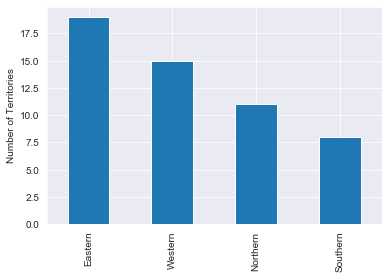

In [236]:
region_plot = counts.plot.bar()
region_plot.set_ylabel('Number of Territories')
region_plot.set_xticklabels(('Eastern', 'Western', 'Northern', 'Southern'))

This table, similar to Region_df, acts as an intermediary table for the 53 unique territories belonging to the 4 regions.  Across these 4 regions, we have region 4 (Southern) that has the least territories (8), then region 3 (Northern) with 11 territories, then region 2 (Western) with 15 territories, and finally region 1 (Eastern) with 19 territories.

### EmployeeTerritory_df

In [238]:
EmployeeTerritory_df.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [239]:
EmployeeTerritory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
Id             49 non-null object
EmployeeId     49 non-null int64
TerritoryId    49 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [241]:
EmployeeTerritory_df.TerritoryId.nunique()

49

In [243]:
EmployeeTerritory_df.EmployeeId.nunique()

9

All 9 employees are accounted for in this table, but oddly only 49 out of the 53 unique territories are accounted for in this table. This might indicate that there are 4 territories that are currently not assigned to any employee.

In [246]:
missing_territories = EmployeeTerritory_df.merge(Territory_df, how="right", left_on='TerritoryId', right_on='Id')

In [249]:
print(missing_territories[missing_territories['Id_x'].isnull()])

   Id_x  EmployeeId TerritoryId   Id_y TerritoryDescription  RegionId
49  NaN         NaN         NaN  29202             Columbia         4
50  NaN         NaN         NaN  72716          Bentonville         4
51  NaN         NaN         NaN  75234               Dallas         4
52  NaN         NaN         NaN  78759               Austin         4


It looks like there are 4 territories within region 4 (Southern) that are not assigned to an employee. These 4 territories are Columbia, Bentonville, Dallas, and Austin.

## Initial Curiosities & Observations

- Some type of performance comparison between employees from US and UK offices (there are only 9 employees total)
- 8 Categories of food&bev, perhaps which categories are the least likely to make first-time buyers repeat their purchase... 
- how do discounts perform (in terms of increased quantity ordered) for different categories... maybe discounts on meat and poultry are higher than discounts on sweets or beverages?
- 91 customers with company data, across 21 countries - group by territory and see if orders are consistent across all regions or if some regions prefer certain categories of products
- 29 suppliers in 16 countries 
- orders table: look at ship date versus order date and see if certain countries outperform others in terms of being faster to ship? or look at late orders and see how employee IDs connected to those orders perform in this sense.
- Product table: We have 77 unique products, 8 of which have been discontinued. Half of those discontinued products belong to the same category (id 6).
- CustomerCustomerDemo and CustomerDemographic have no data available
- Region_df: This simple table provides the 4 regions and their corresponding region IDs. The four regions are Eastern, Western, Northern, and Southern.
- Territory_df: This table, similar to Region_df, acts as an intermediary table for the 53 unique territories belonging to the 4 regions.  Across these 4 regions, we have region 4 (Southern) that has the least territories (8), then region 3 (Northern) with 11 territories, then region 2 (Western) with 15 territories, and finally region 1 (Eastern) with 19 territories.
- All 9 employees are accounted for in this table, but oddly only 49 out of the 53 unique territories are accounted for in this table. This might indicate that there are 4 territories that are currently not assigned to any employee (these 4 unaccounted for territories are all located in Region 4 (Southern)).

## Discount data - Initial Review
Let's begin by taking a look at relevant table for discounts and quantity of product in an order.

In [55]:
# While all the data we need is in the orderdetail table, let's add product names to bring the data to life
c.execute("""SELECT od.orderid, od.productId, p.productname, od.quantity, od.unitprice, od.discount 
                    FROM orderdetail od JOIN product p ON od.productid = p.id;""")
od_df = pd.DataFrame(c.fetchall())
od_df.columns = [x[0] for x in c.description]
od_df.head()

,OrderId,ProductId,ProductName,Quantity,UnitPrice,Discount
0,10248,11,Queso Cabrales,12,14.0,0.0
1,10248,42,Singaporean Hokkien Fried Mee,10,9.8,0.0
2,10248,72,Mozzarella di Giovanni,5,34.8,0.0
3,10249,14,Tofu,9,18.6,0.0
4,10249,51,Manjimup Dried Apples,40,42.4,0.0


In [56]:
od_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
OrderId        2155 non-null int64
ProductId      2155 non-null int64
ProductName    2155 non-null object
Quantity       2155 non-null int64
UnitPrice      2155 non-null float64
Discount       2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [57]:
# Check for any null values as part of pre-processing that might be required
od_df.isnull().sum()

OrderId        0
ProductId      0
ProductName    0
Quantity       0
UnitPrice      0
Discount       0
dtype: int64

In [58]:
# Note: OrderId and ProductId are not relevant for showing valid descriptive statistics
od_df[['UnitPrice', 'Quantity', 'Discount']].describe()

,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [59]:
od_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [60]:
1317 / len(od_df.Discount)

0.6111368909512761

In the OrderDetail table, we should take note of the following:
- the Order ID does repeat, likely because each OrderID can have multiple ProductID's, represented across multiple rows
    - Therefore, quantity is attributable to the quantity of the product within that order.
- Discount appears to be a percentage discount ranging from 0% to 25%
    - roughly 61% of the data in this table has no discount at all
- for Quantity Ordered - the min is 1 and the max is 130

### Discount Data Visualizations

Let's explore a few quick visualizations of quantity ordered followed by quantity ordered split across discounted and non-discounted products

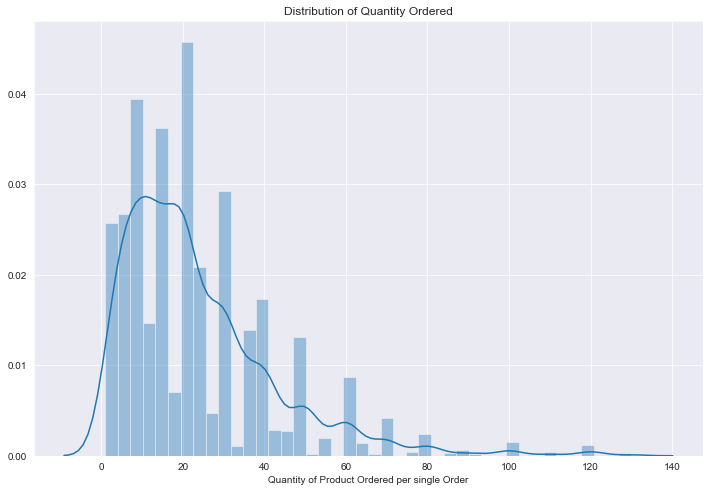

In [61]:
plt.figure(figsize=(12,8))
sns.distplot(od_df['Quantity'])
plt.title('Distribution of Quantity Ordered')
plt.xlabel('Quantity of Product Ordered per single Order')
plt.show()

We can see that Quantity is right-skewed and non-normal. 

In [73]:
# we're splitting the OrderDetail data in two, by non-discounted and discounted orders
od_NOdiscount = od_df.loc[od_df['Discount'] == 0].copy()
od_NOdiscount.describe()

,OrderId,ProductId,Quantity,UnitPrice,Discount
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.0
mean,10662.791951,41.396355,21.715262,26.171534,0.0
std,244.835366,22.217410,17.507493,29.717354,0.0
min,10248.000000,1.000000,1.000000,2.000000,0.0
25%,10448.000000,23.000000,10.000000,12.000000,0.0
50%,10671.000000,41.000000,18.000000,18.400000,0.0
75%,10879.000000,60.000000,30.000000,32.800000,0.0
max,11077.000000,77.000000,130.000000,263.500000,0.0


In [74]:
od_discount = od_df.loc[od_df['Discount'] > 0].copy()
od_discount.describe()

,OrderId,ProductId,Quantity,UnitPrice,Discount
count,838.000000,838.000000,838.000000,838.000000,838.000000
mean,10654.007160,39.844869,27.109785,26.292363,0.144439
std,235.887125,22.046812,20.771439,30.017214,0.071808
min,10250.000000,1.000000,1.000000,2.000000,0.010000
25%,10452.250000,21.000000,12.000000,12.500000,0.100000
50%,10645.000000,40.000000,20.000000,18.000000,0.150000
75%,10847.000000,59.000000,36.000000,31.230000,0.200000
max,11077.000000,77.000000,130.000000,263.500000,0.250000


Now let's look at how quantity ordered compares between discounted and non-discounted products.

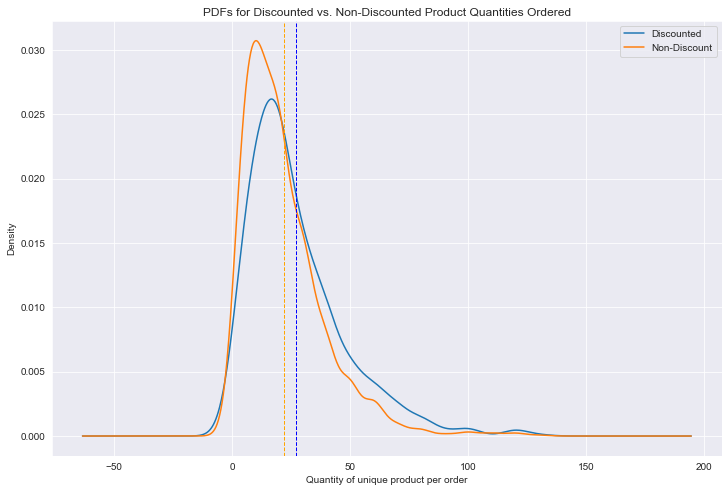

In [46]:
plt.figure(figsize=(12,8))
od_discount.Quantity.plot.kde(label="Discounted")
od_NOdiscount.Quantity.plot.kde(label="Non-Discount")
plt.title("PDFs for Discounted vs. Non-Discounted Product Quantities Ordered")
plt.xlabel('Quantity of unique product per order')
plt.legend()
plt.axvline(od_discount.Quantity.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(od_NOdiscount.Quantity.mean(), color="orange", linestyle="dashed", linewidth=1)
plt.show()

In the above, we can see that quantities ordered for discounted versus non-discounted products shows a slightly higher average for discounted products. Both distributions are skewed right.

### The Products

In [72]:
#look at unique products overall and how these vary across the discounted vs. non-discounted data
print("Total number of unique products: {}".format(od_df.ProductId.nunique()))
print("Number of unique products in Discounted Data: {}".format(od_discount.ProductId.nunique()))
print("Number of unique products in Non-Discounted Data: {}".format(od_NOdiscount.ProductId.nunique()))

Total number of unique products: 77
Number of unique products in Discounted Data: 77
Number of unique products in Non-Discounted Data: 77


Great! It appears that all products have at one point received discounts and at other points received no discounts. 

# Hypothesis Testing:

**p-value**: 

    The probability of observing a test statistic at least as large as the one observed, by random chance, assuming that the null hypothesis is true. If you calculate a p-value and it comes out to 0.03, you can interpret this as saying "There is a 3% chance of obtaining the results I'm seeing when the null hypothesis is true."


**alpha level**:  $\alpha$
    
    The alpha level is the marginal threshold at which you're okay with rejecting the null hypothesis. If you set an alpha value of 𝛼=0.05, you're essentially saying "I'm okay with accepting my alternative hypothesis as true if there is less than a 5% chance that the results that I'm seeing are actually due to randomness."


## Tests and Functions

**Student's T-Test**: 𝑡-tests are a useful method for determining whether the mean of two small samples indicate different underlying population parameters. The reasoning behind this begins with the use of Z-tests to calculate the likelihood of sampling a particular value from a normal distribution. Furthermore, by the central limit theorem, the mean of a sample is a normally distributed variable centered around the actual underlying population mean. That said, 𝑡-tests are more appropriate for small samples (n_observations < 30), due to disproportionate tails. Finally, recall that the t-distribution actually converges to a normal distribution as the degrees of freedom continues to increase.

**Welch's T-Test**: Traditional t-tests assume that sample sizes and sample variances between the two groups are equal. When these assumptions are not met, Welch's T-test is generally a more reliable test.

*Functions for welch's ttest, ddof, and p-value are provided in welch txt file.* 

**Cohen's d** - this is a measure that expresses the size of an effect in terms of the number of standard deviations, similar to a 𝑧-score in statistics.

 - d=0.2 be considered a 'small' effect size
 - d=0.5 represents a 'medium' effect size
 - d=0.8 a 'large' effect size.

In [124]:
# to calculate effect size
def Cohen_d(a, b):
    diff_mu_a_b = a.mean() - b.mean()
    n_a, n_b = len(a), len(b)
    var_a = a.var()
    var_b = b.var()
    
    pooled_var = (n_a*var_a + n_b*var_b) / (n_a + n_b)
    
    d = diff_mu_a_b / np.sqrt(pooled_var)
    return abs(d)

In [129]:
#visualization function for when there are two samples to compare
def visualization(control, experimental):
    plt.figure(figsize=(12,8))
    sns.distplot(experimental, bins=50, label="Experimental")
    sns.distplot(control, bins=50, label="Control")
    # add lines for sample means - adjust if different parameter is being tested
    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')
    
    plt.title("Control vs. Experimental Sample Distributions", fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Q1a: Does discount amount have a statistically significant effect on the quantity of a product in an order? (Q1b) If so, at what level(s) of discount?

### Formulated Hypotheses & Parameters:
- $H_0: \mu_a = \mu_b$ *There is no difference in quantity ordered of a product per order between discounted and non-discounted products.*

- $H_1: \mu_a > \mu_b$ *Quantity ordered of a product per order for discounted products is higher than quantity ordered of a product per order without discounts.*

- $\alpha$: 0.05

- I will use a **One-Tail Test** because I want to know if a parameter from the treatment group (discounted) is higher than the corresponding parameter from the control group (non-discounted).

- I will use the Welch's T-Test because the normality assumption between our two subsets of data is not met.

### Welch's T-Test

In [115]:
#welch's ttest stat
q1a_welch_t = welch_t(od_discount.Quantity, od_NOdiscount.Quantity)

In [116]:
#calculate the ddof for welch's ttest
q1a_ddof = welch.welch_df(od_discount.Quantity, od_NOdiscount.Quantity)

In [120]:
# set two_sided parameter to false
q1a_pval = welch.p_value_welch_ttest(od_discount.Quantity, od_NOdiscount.Quantity, two_sided=False)

In [121]:
print(q1a_pval)

2.8282065578366655e-10


Our p-value is well below the alpha level set, meaning we can reject the Null Hypothesis and state that there is a statistically significant difference between quantity ordered for discounted products versus quantity ordered when there is no discount provided. Now let's take a look at effect size to understand this difference in greater detail.

### Effect Size

We will calculate Cohen's D to assess whether the difference in the sample parameters is considered a small, medium, or large effect

In [125]:
print("Cohen's d: {}".format (Cohen_d(od_discount.Quantity, od_NOdiscount.Quantity)))

Cohen's d: 0.2862724481729282


### Interpretation of Results

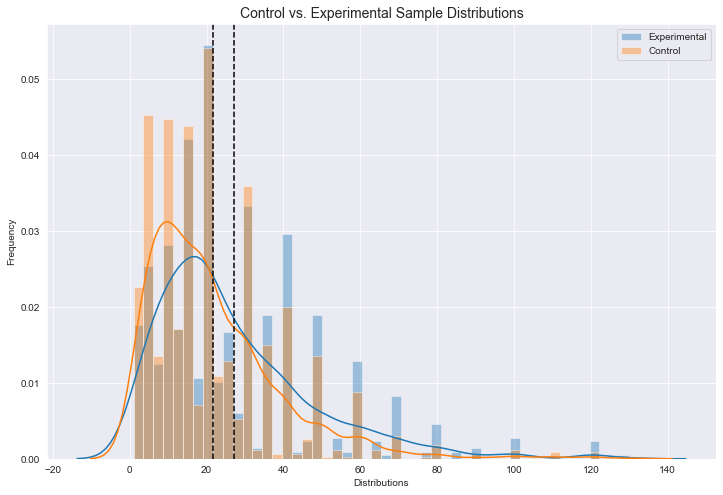

In [130]:
visualization(od_NOdiscount.Quantity, od_discount.Quantity)

In [119]:
print("Hypothesis Testing Results for Q1a")
print("Welch's t-stat: {} \tP-Value: {}".format(q1a_welch_t, q1a_pval))
print("Cohen's d (effect size): {}".format(Cohen_d(od_discount.Quantity, od_NOdiscount.Quantity)))

Hypothesis Testin Results for Q1a
Welch's t-stat: 6.239069142123973 	P-Value: 5.656413115673331e-10
Cohen's d (effect size): 0.2862724481729282


In [131]:
mean_discounted, mean_nondiscounted = od_discount.Quantity.mean(), od_NOdiscount.Quantity.mean()
print("Avg quantity ordered with discount: {} \nAvg quantity ordered withOUT discount: {}".format(mean_discounted, mean_nondiscounted))

Avg quantity ordered with discount: 27.10978520286396 
Avg quantity ordered withOUT discount: 21.715261958997722


Given the low p-value produced from the Welch's T-Test, we are able to Reject the Null Hypothesis in favor of the Alternate Hypothesis, meaning that the average quantity ordered when a discount is available is higher than occasions where no discount is provided. Specifically, the average quantity ordered of a product is 27 under a discount, compared to ~22 on average for no discounts; this difference is statistically significant. That being said, our effect size (reflected in the standardized score provided by the Cohen's d measure) shows that the effect size is considered small at 0.286.

### Q1b: If so, at what level(s) of discount?

In order to determine at which level(s) of discount we can see a statistically significant difference in quantity ordered, we need to perform a one-way ANOVA test using discount levels as a categorical variable. 

In [133]:
# showing descriptive stats for Quantity ordered at each discount level provided
od_discount['Quantity'].groupby(od_df['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0


ANOVA has the following assumptions:

- The response variable (discount level) should have a normal distribution - *this is not the case*
- The population variances are equal
- The response variables are independent

While the first two assumptions are not met, given the large enough sample size we can consider our sampling distribution to be robust, and we will proceed with ANOVA.

We can see that at the 1%, 4% and 6% discount levels, we only have a quantity of 1, and at 2% and 3% we have a quantity of 2 for each.  We may consider binning these into the 5% discount level that way we have sufficient sample in each discount level.

In [136]:
# convert 1-6% discount levels into the 5% discount level
q1b_data = od_discount.copy()
q1b_data['Discount'] = q1b_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
q1b_data['Discount'].value_counts()

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

In [138]:
# wrap 'Discount' with 'C()' to indicate this is a categorical variable
q1b_results = ols('Quantity ~ C(Discount)', data=q1b_data).fit()

In [139]:
q1b_anova_table = sm.stats.anova_lm(q1b_results, typ=2)
print(q1b_anova_table)

                    sum_sq     df         F    PR(>F)
C(Discount)    1065.701253    4.0  0.616376  0.650947
Residual     360060.198508  833.0       NaN       NaN


In the right column, we can see that our p-value is quite high, meaning we fail to reject the null hypothesis, meaning that the null is true (there is no difference in quantity ordered at various levels of discounts).

## Q2: Is there a difference in performance between US and UK employees?


There are several ways that we could think about performance metrics for employees, including number of orders processed per employees from these two countries, processing time for orders, total price of orders, customer/client repeats, etc.  Let's start with looking at number of orders processed.

### Formulated Hypotheses:

- **$H_0: \mu_a = \mu_b$** - *Avg number of orders processed by employees in the US and the UK are the same.*
    
- **$H_1: \mu_a \neq \mu_b$** - *Avg number of orders processed by employees in the US and the UK are different.*

- **$\alpha$: 0.025:** - *We will set our alpha level as 0.025, thereby reducing the risk of a Type I error while slightly increasing the risk of Type II errors*

- We will run a Two-Sample T-Test, and compare with ANOVA analysis as well.

### Test

In [254]:
Employee_df.columns

Index(['Id', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate',
       'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country',
       'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath'],
      dtype='object')

In [255]:
Order_df.columns

Index(['Id', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate',
       'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress',
       'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry'],
      dtype='object')

In [289]:
c.execute("""SELECT o.employeeid, e.lastname, e.firstname, e.title, e.hiredate, e.country, 
                    COUNT(o.id) as TotalOrders 
                    FROM employee e JOIN [order] o 
                    ON o.employeeid = e.id GROUP BY o.employeeid;""")
emp_orders = pd.DataFrame(c.fetchall())
emp_orders.columns = [x[0] for x in c.description]
emp_orders

,EmployeeId,LastName,FirstName,Title,HireDate,Country,TotalOrders
0,1,Davolio,Nancy,Sales Representative,2024-05-01,USA,123
1,2,Fuller,Andrew,"Vice President, Sales",2024-08-14,USA,96
2,3,Leverling,Janet,Sales Representative,2024-04-01,USA,127
3,4,Peacock,Margaret,Sales Representative,2025-05-03,USA,156
4,5,Buchanan,Steven,Sales Manager,2025-10-17,UK,42
5,6,Suyama,Michael,Sales Representative,2025-10-17,UK,67
6,7,King,Robert,Sales Representative,2026-01-02,UK,72
7,8,Callahan,Laura,Inside Sales Coordinator,2026-03-05,USA,104
8,9,Dodsworth,Anne,Sales Representative,2026-11-15,UK,43


Text(0.5, 1, 'Number of Orders by Employees in US and UK')

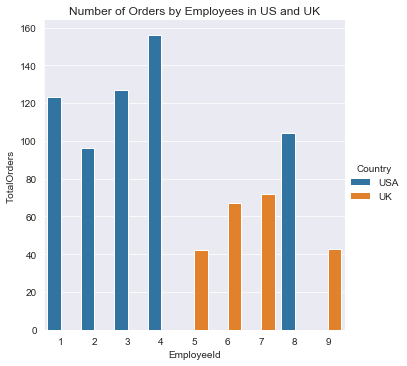

In [448]:
sns.catplot(x='EmployeeId', y='TotalOrders', kind='bar', hue='Country', data=emp_orders)
plt.title('Number of Orders by Employees in US and UK')

Now that we have the data we need on total orders for each employee, let's slice this dataframe between the two employee countries.  We can see quite a range between total orders by the 9 different employees.

In [290]:
usa_emp_orders = emp_orders.loc[emp_orders['Country'] == 'USA'].copy()
uk_emp_orders = emp_orders.loc[emp_orders['Country'] == 'UK'].copy()

In [298]:
#two sample t-test
results = stats.ttest_ind(usa_emp_orders.TotalOrders, uk_emp_orders.TotalOrders, equal_var=True)
#p-value set at 0.025
alpha = .025
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject the null hypothesis, the avg number of orders between US and UK employees is not the same.")
else:
    print("Fail to Reject the Null Hypothesis")

Reject the null hypothesis, the avg number of orders between US and UK employees is not the same.


In [301]:
print("Two-Sample T-Test p-value: {}".format(results[1]))

Two-Sample T-Test p-value: 0.002063854331616113


In [295]:
# Let's perform an ANOVA test, treating Country as a category
formula = 'TotalOrders ~ C(Country)'
lm = ols(formula, emp_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq   df          F    PR(>F)
C(Country)  9446.755556  1.0  22.640129  0.002064
Residual    2920.800000  7.0        NaN       NaN


### Effect Size

In [303]:
print("Cohen's d (effect size): {}".format(Cohen_d(usa_emp_orders.TotalOrders, uk_emp_orders.TotalOrders)))

Cohen's d (effect size): 3.210081976551365


### Interpretation of Results

In [305]:
print("US avg orders per employee: {} \t UK avg orders per employee: {}".format(usa_emp_orders.TotalOrders.mean(), uk_emp_orders.TotalOrders.mean()))

US avg orders per employee: 121.2 	 UK avg orders per employee: 56.0


Above, we ran both a two-sample t-test and ANOVA to understand if the difference between the performance of US versus UK employees, via total number of orders, is statistically different. Given the fact that we only have two categories (US versus UK) the ANOVA p-value and the student's t-test p-value produced are the same, as expected. With a p-value of 0.002 we can Reject the Null Hypothesis.  The effect size is also quite large, indicated by the Cohen's d-stat of 3.2.  US employees have an average order total of 121.2 orders, compared to UK employees who average 56 orders.

## Q3: Is there a difference in order processing time (from OrderDate to ShipDate) across the 3 different Shipping companies?


We will test this hypothesis out with the recognition that processing time may not be fully attributable to the Shipping company, meaning it might be the employee that acts as an intermediary between the order date and notifying the Shipping company. Given this, should there be a major difference in processing time for one or multiple shipping companies, we should dig deeper to understand the processes behind placing and order and when the shipping company is notified of the order details. We may also want to run this same processing-time-analysis against the employees responsible for each order.

### Formulated Hypotheses:

- $H_0: \mu_a = \mu_b = \mu_c$ - *The average time from order date to ship date between the three different shipping companies is the same.*
- $H_1: \mu_a \neq \mu_b \neq \mu_c$ - *The average time from order date to ship date between the three difference shipping companies is not the same.*

- $\alpha$: 0.05/3 = 0.01667 (see below)

- Given the fact that we have three different shipping companies (3 samples) we must address the Multiple Comparisons Problem. We will use the Bonferroni Correction to correct for this, in an effort to minimize Type I errors.

In [317]:
# extract most data from Order table plus shipping company name from Shipper table
c.execute("""SELECT o.id, o.employeeid, o.orderdate, o.requireddate, o.shippeddate, o.shipvia, s.companyname 
                FROM [order] o JOIN shipper s ON o.shipvia = s.id;""")
order_ship = pd.DataFrame(c.fetchall())
order_ship.columns = [x[0] for x in c.description]
order_ship.head()

,Id,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,CompanyName
0,10248,5,2012-07-04,2012-08-01,2012-07-16,3,Federal Shipping
1,10249,6,2012-07-05,2012-08-16,2012-07-10,1,Speedy Express
2,10250,4,2012-07-08,2012-08-05,2012-07-12,2,United Package
3,10251,3,2012-07-08,2012-08-05,2012-07-15,1,Speedy Express
4,10252,4,2012-07-09,2012-08-06,2012-07-11,2,United Package


In [318]:
#Quick check on null values, as NaN in date columns means we cannot use those orders as observations for this test
order_ship.isnull().sum()

Id               0
EmployeeId       0
OrderDate        0
RequiredDate     0
ShippedDate     21
ShipVia          0
CompanyName      0
dtype: int64

In [319]:
# drop the 21 null values as we cannot use these to compute the processing time
order_ship.dropna(inplace=True)

In [321]:
# change column data types for datetime, then subtract order date from shipping date to provide processing time
import datetime
order_ship['OrderDate'] = pd.to_datetime(order_ship['OrderDate'])
order_ship['ShippedDate'] = pd.to_datetime(order_ship['ShippedDate'])
# add a column for the processing time
order_ship['ProcessingTime'] = order_ship['ShippedDate'] - order_ship['OrderDate']
order_ship['ProcessingTime'] = order_ship['ProcessingTime'].dt.days
order_ship.head()

,Id,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,CompanyName,ProcessingTime
0,10248,5,2012-07-04,2012-08-01,2012-07-16,3,Federal Shipping,12
1,10249,6,2012-07-05,2012-08-16,2012-07-10,1,Speedy Express,5
2,10250,4,2012-07-08,2012-08-05,2012-07-12,2,United Package,4
3,10251,3,2012-07-08,2012-08-05,2012-07-15,1,Speedy Express,7
4,10252,4,2012-07-09,2012-08-06,2012-07-11,2,United Package,2


In [333]:
# descriptive stats on processing time per company
order_ship['ProcessingTime'].groupby(order_ship['CompanyName']).describe()

,count,mean,std,min,25%,50%,75%,max
CompanyName,,,,,,,,
Federal Shipping,249.0,7.473896,5.680357,1.0,4.0,6.0,9.0,35.0
Speedy Express,245.0,8.571429,6.777494,1.0,5.0,7.0,9.0,37.0
United Package,315.0,9.234921,7.601671,1.0,4.0,7.0,10.0,37.0


At first glance, the sample sizes are relatively similar and the means seem pretty close. Interestingly, as the means increase so do the standard deviations.

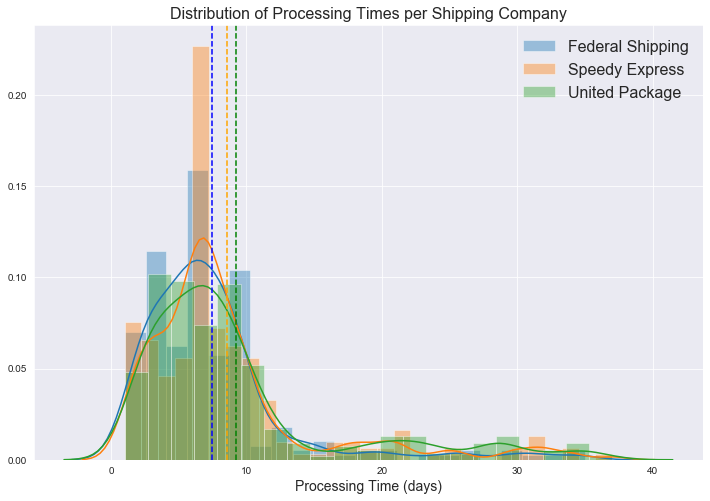

In [330]:
# plot each of the three processing time distributions
FedShip = order_ship.loc[order_ship['CompanyName']=='Federal Shipping']['ProcessingTime']
SpeedyExpress = order_ship.loc[order_ship['CompanyName']=='Speedy Express']['ProcessingTime']
UnitedPack = order_ship.loc[order_ship['CompanyName']=='United Package']['ProcessingTime']

plt.figure(figsize=(12, 8))
sns.distplot(FedShip, label='Federal Shipping')
sns.distplot(SpeedyExpress, label='Speedy Express')
sns.distplot(UnitedPack, label='United Package')
plt.axvline(x=FedShip.mean(), color='blue', linestyle='--')
plt.axvline(x=SpeedyExpress.mean(), color='orange', linestyle='--')
plt.axvline(x=UnitedPack.mean(), color='green', linestyle='--')
plt.title('Distribution of Processing Times per Shipping Company', fontsize=16)
plt.xlabel('Processing Time (days)', fontsize=14)

plt.legend(frameon=False, fontsize=16, loc='best')

We can see that all three of the distributions are right skewed, however each of the distributions resemble each other and have large sample sizes (all with n>200).

In [341]:
#look at variance for each distribution
print("Variances for each company's processing time:")
print("FedShip: {} \tSpeedyExpress: {} \tUnitedPack: {}".format(np.var(FedShip), np.var(SpeedyExpress), np.var(UnitedPack)))

Variances for each company's processing time:
FedShip: 32.136868760181294 	SpeedyExpress: 45.746938775510216 	UnitedPack: 57.60195515243134


### Test

We are running an ANOVA test to test if there are differences amongst the three shipping companies' average processing time. While the distributions are not normal and the variances are not equal, we have robust sampling distributions based on the sufficient sample sizes for each company's processing time. We can also assume independence amongst the response variables as well and proceed with the ANOVA test.

In [335]:
#run ANOVA test treating CompanyName as a categorical variable
formula = 'ProcessingTime ~ C(CompanyName)'
lm = ols(formula, order_ship).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df         F    PR(>F)
C(CompanyName)    433.501581    2.0  4.676819  0.009563
Residual        37354.696194  806.0       NaN       NaN


While the ANOVA test allows us to determine whether there is a statistically significant difference between the company means, it doesn't provide insight as to which means are different.  In order to determine this, we need to perform a multiple comparisons analysis, which we will do using Tukey's HSD test to conduct all possible pairwise tests.

In [336]:
mc = MultiComparison(order_ship['ProcessingTime'], order_ship['CompanyName'])
mc_results = mc.tukeyhsd()
print(mc_results)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
Federal Shipping Speedy Express   1.0975 0.1733 -0.3409  2.536  False
Federal Shipping United Package    1.761 0.0067  0.4055 3.1165   True
  Speedy Express United Package   0.6635 0.4887 -0.6982 2.0252  False
---------------------------------------------------------------------


### Interpretation of Results

We adjusted our alpha level according to the Bonferroni Correction to address the Multiple Comparison's Problem, meaning that our original intent of having an 0.05 alpha level was divided by 3 (for each of the shipping companies) leaving us with a more stringent alpha level of 0.01667.

The results of the ANOVA test show that p-value of 0.00956 is less than our alpha level of 0.01667, so we can Reject the Null Hypothesis and state that there is a statistically significant difference between the average processing times for each of these shipping companies.

After rejecting the null hypothesis given our ANOVA test results, we performed the Tukey's HSD test, and from there we can see that we're able to reject the null hypothesis only for comparing Federal Shipping and United Package. There is a statistically significant difference in average processing time between Federal Shipping and United Package, where the former has an average processing time of 7.5 days compared to United Package's average processing time of 9.2 days.

## Q4: Is there any interaction between Category and Customer Region in terms of total revenue per category?


Let's explore how demand for categories in different customer regions interact by looking at total revenues.

### Formulated Hypotheses:

- $H_0: \mu_a = \mu_b$ - *There is no interaction between category and customer region in regards to total revenues for a category in a region.*
- $H_1: \mu_a \neq \mu_b$ - *There is a statistically significant interaction between category and customer region in regards to total revenues for a category in a region.*

- $\alpha$: 0.05

- We will use a two-way ANOVA test, as we are testing the interaction between two categorical variables, followed by a Tukey's HSD test to examine the results more closely.

In [426]:
# gather necessary data from order, orderdetail, product, and category tables
q4_data = pd.merge(Order_df, OrderDetail_df, 
                  left_on='Id',
                  right_on='OrderId', 
                  how='left')
q4_data = pd.merge(q4_data, Customer_df, 
                  left_on='CustomerId', 
                  right_on='Id',
                  how='left')
q4_data = pd.merge(q4_data, Product_df, 
                  left_on='ProductId', 
                  right_on='Id', 
                  how='left')
q4_data = pd.merge(q4_data, Category_df, 
                  left_on='CategoryId', 
                  right_on='Id', 
                  how='left')
q4_data = q4_data.rename(index=str, columns={"UnitPrice_x": "UnitPrice"})
q4_data = q4_data.rename(index=str, columns={"Region": "CustomerRegion"})
q4_data['Revenue'] = q4_data['Quantity']*(q4_data['UnitPrice'])
q4_data = q4_data[['CustomerRegion', 'CategoryName', 'Revenue']]
q4_data.head()

,CustomerRegion,CategoryName,Revenue
0,Western Europe,Dairy Products,168.0
1,Western Europe,Grains/Cereals,98.0
2,Western Europe,Dairy Products,174.0
3,Western Europe,Produce,167.4
4,Western Europe,Produce,1696.0


In [427]:
q4_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2155 entries, 0 to 2154
Data columns (total 3 columns):
CustomerRegion    2078 non-null object
CategoryName      2155 non-null object
Revenue           2155 non-null float64
dtypes: float64(1), object(2)
memory usage: 67.3+ KB


In [428]:
q4_data.isnull().sum()

CustomerRegion    77
CategoryName       0
Revenue            0
dtype: int64

In [429]:
#remove null values as we cannot determine interaction with customer region data
q4_data.dropna(inplace=True)

Given the fact that we have two categorical variables, Region and Category, we will employ a two-way ANOVA test, followed by a Tukey's HSD test.

Text(0, 0.5, 'Revenue')

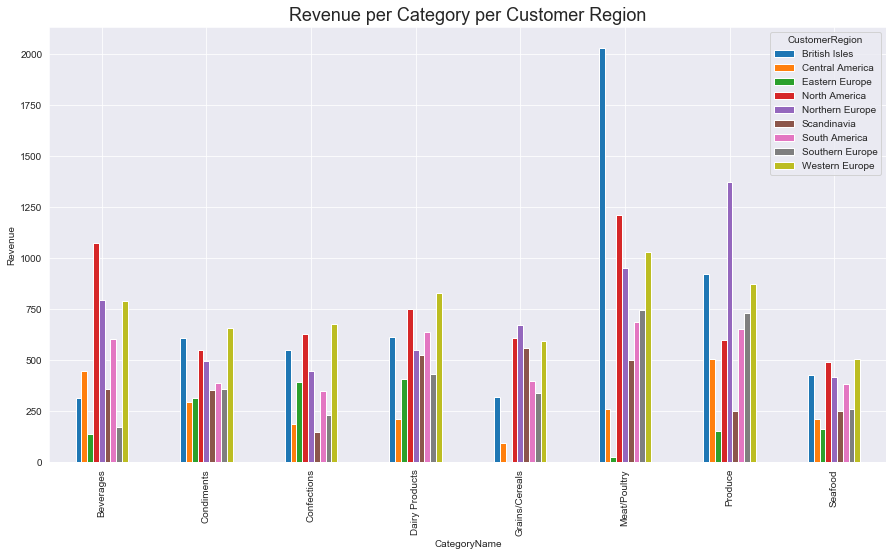

In [432]:
#visualize the table showing total revenues per category per region
fig = q4_data.pivot_table(values='Revenue', index='CategoryName', columns='CustomerRegion').plot.bar(figsize=(15,8))
plt.title('Revenue per Category per Customer Region', fontsize=18)
plt.ylabel('Revenue')

### Test

In [435]:
#run two way ANOVA test with C wrapped around both categorical variables
formula = 'Revenue ~ C(CustomerRegion)*C(CategoryName)'
lm = ols(formula, q4_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

/Users/serenaquiroga/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  'rank is %d' % (J, J_), ValueWarning)
/Users/serenaquiroga/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
/Users/serenaquiroga/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 55
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(CustomerRegion),4.943779e+07,8.0,5.925161,7.730724e-07
C(CategoryName),5.150479e+07,7.0,7.054735,1.898329e-07
C(CustomerRegion):C(CategoryName),4.377659e+07,56.0,0.749523,9.136929e-01
Residual,2.093227e+09,2007.0,NaN,NaN


We can see that the interaction between CustomerRegion and Category has a high p-value, and we fail to reject the null hypothesis.  There is no interaction between Category and Customer Region in regards to total revenues for each category.  Despite this result, we can still utilize the Tukey's HSD for each category to compare each region.

In [433]:
# Run Tukey's HSD Test for each category and customer region interaction
results = []
for i in q4_data['CategoryName'].unique():
    mc = MultiComparison(q4_data['Revenue'][q4_data['CategoryName'] == i], q4_data['CustomerRegion'][q4_data['CategoryName'] == i])
    result = mc.tukeyhsd()
    results.append(result)
    print (i)
    print(result)

Dairy Products
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff p-adj    lower      upper   reject
----------------------------------------------------------------------------
  British Isles Central America -399.0452 0.7655 -1166.9483  368.8578  False
  British Isles  Eastern Europe -205.6452    0.9 -1903.5428 1492.2523  False
  British Isles   North America  137.9243    0.9  -321.2072  597.0558  False
  British Isles Northern Europe  -61.3276    0.9  -735.7029  613.0478  False
  British Isles     Scandinavia  -86.5068    0.9  -831.0841  658.0706  False
  British Isles   South America   24.6323    0.9   -468.681  517.9456  False
  British Isles Southern Europe -179.8738    0.9  -903.8598  544.1121  False
  British Isles  Western Europe  216.6532 0.7624  -198.9585   632.265  False
Central America  Eastern Europe     193.4    0.9 -1598.3738 1985.1738  False
Central America   North America  536.9696 0.3553  -196.7872 1

Seafood
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff p-adj    lower      upper   reject
----------------------------------------------------------------------------
  British Isles Central America -218.6597    0.9  -799.9568  362.6375  False
  British Isles  Eastern Europe -268.5347    0.9 -1753.5545 1216.4852  False
  British Isles   North America   63.8042    0.9  -261.9629  389.5713  False
  British Isles Northern Europe  -12.9236    0.9   -400.455  374.6079  False
  British Isles     Scandinavia -177.2124    0.9  -732.4291  378.0042  False
  British Isles   South America  -44.3607    0.9  -372.8935  284.1721  False
  British Isles Southern Europe -166.0235    0.9  -609.5054  277.4584  False
  British Isles  Western Europe   77.8936    0.9  -223.6007  379.3878  False
Central America  Eastern Europe   -49.875    0.9 -1599.3633 1499.6133  False
Central America   North America  282.4639 0.7751  -266.8577  831.785

Meat/Poultry
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1          group2      meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------------------
  British Isles Central America -1771.0233 0.3045 -4114.8972  572.8505  False
  British Isles  Eastern Europe -2010.0533    0.9  -6697.801 2677.6943  False
  British Isles   North America  -821.1824 0.6076  -2190.822  548.4573  False
  British Isles Northern Europe -1080.4998 0.5305 -2767.2051  606.2056  False
  British Isles     Scandinavia -1531.0819 0.3382  -3608.704  546.5402  False
  British Isles   South America -1348.0744 0.1667 -2934.8845  238.7356  False
  British Isles Southern Europe -1286.5462 0.2921 -2973.2515  400.1591  False
  British Isles  Western Europe -1002.5728 0.3051 -2330.0307  324.8851  False
Central America  Eastern Europe    -239.03    0.9 -5211.1372 4733.0772  False
Central America   North America    949.841    0.9 -

### Interpretation of Results

The results of the ANOVA test show a high F-stat (9.136929e-01), meaning we Fail to Reject the Null Hypothesis.  Furthermore, the Tukey's HSD Test also confirms no statistically significant differences in the interactions between Category and Customer Region as it affects Total Revenue per category.

# Conclusion

## Summary of Findings:

- **Discounts increase the average quantity ordered of a product, although the effect size is considered small at 0.2.**
    - Given the low p-value produced from the Welch's T-Test, we are able to Reject the Null Hypothesis in favor of the Alternate Hypothesis, meaning that the average quantity ordered when a discount is available is higher than occasions where no discount is provided. 
    - Specifically, the average quantity ordered of a product is 27 under a discount, compared to ~22 on average for no discounts; this difference is statistically significant. That being said, our effect size (reflected in the standardized score provided by the Cohen's d measure) shows that the effect size is considered small at 0.286.
- **There is a statistically significant difference between the mean number of orders managed by US versus UK employees.**
    - US employees have an average order total of 121.2 orders, compared to UK employees who average 56 orders.
    - we ran both a two-sample t-test and ANOVA to understand if the difference between the performance of US versus UK employees, via total number of orders, is statistically different. Given the fact that we only have two categories (US versus UK) the ANOVA p-value and the student's t-test p-value produced are the same, as expected. 
    - With a p-value of 0.002 we were able to Reject the Null Hypothesis. The effect size is also quite large, indicated by the Cohen's d-stat of 3.2. 
- **Across the 3 Shipping Companies, United Package has the lengthiest processing time of 9.2 days on average, compared to Federal Shipping’s average of 7.5 days.**
    - The results of the ANOVA test show that p-value of 0.00956 was less than our alpha level of 0.01667, so we were able to Reject the Null Hypothesis and state that there is a statistically significant difference between the average processing times for each of these shipping companies.
    - After rejecting the null hypothesis given our ANOVA test results, we performed the Tukey's HSD test, and from there we saw that we're able to reject the null hypothesis only for comparing Federal Shipping and United Package. 
        - There is a statistically significant difference in average processing time between Federal Shipping and United Package, where the former has an average processing time of 7.5 days compared to United Package's average processing time of 9.2 days.
- There is no statistically significant interaction between Category and Customer Region in terms of the effect on Total Revenue per category. 
    - The results of the ANOVA test show a high F-stat (9.136929e-01), meaning we Fail to Reject the Null Hypothesis. Furthermore, the Tukey's HSD Test also confirms no statistically significant differences in the interactions between Category and Customer Region as it affects Total Revenue per category.

## Further Considerations

- Additional analysis should be conducted to understand **for which categories and/or products providing a discount will likely generate increases to quantity ordered.**
- Before devising a strategy to address the **discrepancies in employee performance** (as indicated through order load), additional investigation is required to determine:
    - what the optimal level of orders per employee should be, with consideration of maintaining client satisfaction, avoiding overload, variations in processes for processing different order types (perhaps dealing with certain regions, suppliers, categories, is more or less time-consuming)
    - evaluate any existing sales incentives
    - define other metrics for employee performance, to be considered in conjunction with the order load metric.
- Refine analysis of shipping companies' to consider **costs and expediency of certain orders.**
- We noted earlier that of the 8 discontinued products, 4 of them were from the meat/poultry category (CategoryId 6). We can see that these 4 meat/poultry products that have been discontinued came from 4 separate suppliers, indicating that the cause of their being discontinued isn't tied to a single supplier's actions. We also know that meat/poultry is a significant source of revenue for the company, as such sudden disruption in product offerings could have notable effects on company revenue.